# Nebular models with higher spectral resolution fitting test 1

Note: Rest Wavelengths: $\lambda_{H\alpha}$ = 6564.610 A. $\lambda_{H\beta}$ = 4862.683 A

Observed Wavelengths: $\lambda_{H\alpha}$ = 6892.841 A. $\lambda_{H\beta}$ = 5105.817 A

In [16]:
import bagpipes as pipes
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import simps
from numpy import trapz

goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str")

## $A_{V}$ = 0.1 with nebular component (no masking)

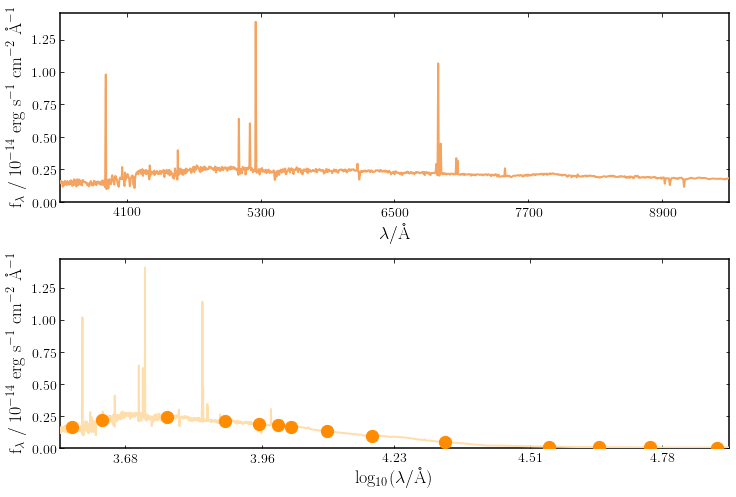

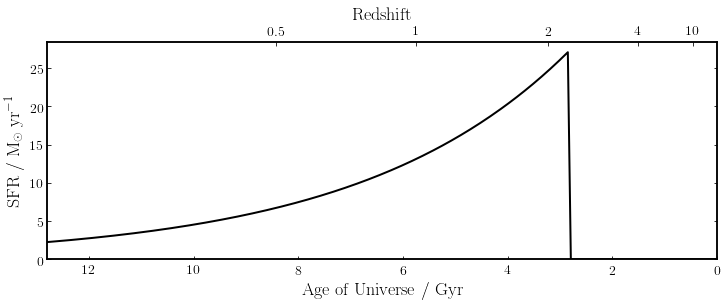

In [17]:
exp = {}                         # Tau-model star-formation history component
exp["age"] = 10.                 # Gyr
exp["tau"] = 4.                  # Gyr
exp["massformed"] = 11.          # log_10(M*/M_solar)
exp["metallicity"] = 1.          # Z/Z_oldsolar

dust = {}
dust["type"] = "CF00"
dust["eta"] = 2.
dust["Av"] = 0.1
dust["n"] = 0.7 

nebular = {}
nebular["logU"] = -2.          # Log_10 of the ionization parameter.

model_components = {}                   # The model components dictionary
model_components["redshift"] = 0.05      # Observed redshift  
model_components["exponential"] = exp
model_components["dust"] = dust
model_components["nebular"] = nebular

model = pipes.model_galaxy(model_components, filt_list=goodss_filt_list, spec_wavs=np.arange(3500., 9500.))

fig = model.plot()
sfh = model.sfh.plot()

In [18]:
#Saves model data to a new file
np.savetxt('emtest1a.txt', model.spectrum, delimiter=',')

#Loads orginal model data
spec = np.loadtxt("emtest1a.txt",delimiter=',')

#Extracts the flux and wavelength arrays
fluxes = spec[:,1]
wavelen = spec[:,0]

# Set a target SNR
# target_snr_flux = 10
# Calculate average flux and flux noise
sig_avg_flux = np.mean(fluxes)
noise_avg_flux = sig_avg_flux/10
# Generate an sample of white noise
mean_noise = 0
noise_flux = np.random.normal(mean_noise, noise_avg_flux, len(fluxes))
# Noise up the original signal
flux_adj = fluxes + noise_flux

#Reshapes the flux, wavelength and error into column arrays
fluxes_arr = flux_adj.reshape(6000,1)
wavelen_arr = spec[:,0].reshape(6000,1)
error_arr = np.array([noise_avg_flux]*6000).reshape(6000,1)

#Appends the three arrays into a three columns
spec_file1 = np.append(wavelen_arr,fluxes_arr,axis=1)
spec_file2 = np.append(spec_file1,error_arr,axis=1)

#Saves the new noisy flux data to a new file
np.savetxt('emtest1b.txt', spec_file2, delimiter=',')

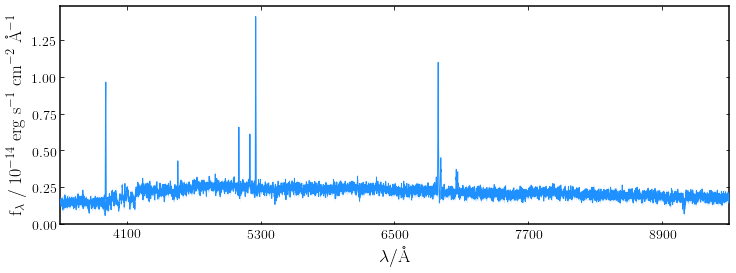

In [19]:
#Function to loads the noisy data file corresponding to the model above
def load_spec(ID):
    """ Loads VANDELS spectroscopic data from file. """

    spec = np.loadtxt("emtest"+ID+".txt",delimiter=',')
    
    return spec

#Retrieve noisy data and plot
galaxy1 = pipes.galaxy("1b", load_spec, photometry_exists=False)
fig1 = galaxy1.plot()

In [8]:
#Fit instructions with ranges for each parameter
exp = {}                          # Tau-model star-formation history component
exp["age"] = (8.,12.)             # Gyr
exp["tau"] = (2.,6.)              # Gyr
exp["massformed"] = (5.,20.)      # log_10(M*/M_solar)
exp["metallicity"] = (0., 2.)     # Z/Z_oldsolar

dust = {}                         # Dust component
dust["type"] = "CF00"             # Define the shape of the attenuation curve
dust["eta"] = (1.,3.)
dust["Av"] = (0.,1.)
dust["n"] = (0.5,1.) 

nebular = {}
nebular["logU"] = -2.

fit_instructions = {}                   # The model components dictionary
fit_instructions["redshift"] = 0.05     # Observed redshift 
fit_instructions["exponential"] = exp
fit_instructions["dust"] = dust
fit_instructions["nebular"] = nebular

#Applies the fit instructions to the noisy data
#Saves the new fit posterior and plots to new file space
fit1 = pipes.fit(galaxy1, fit_instructions, run="Emtest1")
fit1.fit(verbose=False)


Bagpipes: fitting object 1b


Completed in 1083.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.138      0.151      0.165
dust:eta                       2.971      2.989      2.997
dust:n                         0.500      0.502      0.504
exponential:age                8.007      8.022      8.049
exponential:massformed        10.970     10.972     10.974
exponential:metallicity        0.936      0.946      0.956
exponential:tau                2.831      2.878      2.929




In [9]:
#Loads posteriors
fit1.posterior.get_advanced_quantities()
fig = fit1.plot_spectrum_posterior(save=True, show=True)

# Find max likelihood model - extract spectrum and photometry
nsamples = fit1.posterior.samples2d.shape[0]
lnlike = np.zeros(nsamples)
for j in range(nsamples):
        lnlike[j] = fit1.fitted_model.lnlike(fit1.posterior.samples2d[j, :])

        #print(np.min(lnlike))
        #print(np.argmin(lnlike))
    

        ind_bestfit = np.argmin(lnlike)
        fit1.fitted_model.lnlike(fit1.posterior.samples2d[ind_bestfit, :])

        model_bestfit = fit1.fitted_model.model_galaxy
        spectrum_bestfit = model_bestfit.spectrum[:, 1]

        spectrum = fit1.galaxy.spectrum
        spectrum_out = np.lib.pad(spectrum, ((0,0),(0,3)), 'constant', 
                          constant_values=(0))

med_spec = np.percentile(fit1.posterior.samples["spectrum"], 50, axis=0)
if "calib" in list(fit1.posterior.samples):
    calib = np.percentile(fit1.posterior.samples["calib"], 50, axis=0)
    spectrum_out[:,3] = med_spec
if "calib" in list(fit1.posterior.samples):
    spectrum_out[:,4] = calib
    spectrum_out[:,5] = spectrum_bestfit

(6800, 7150)

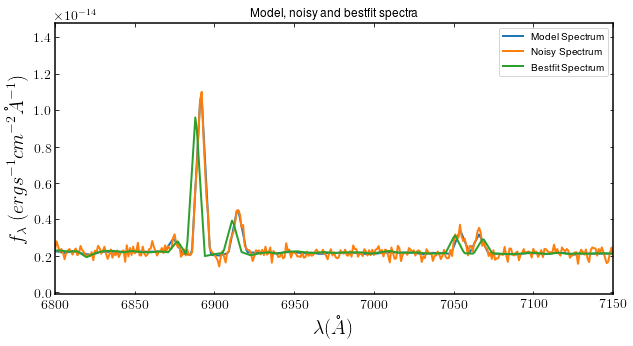

In [21]:
#loads model spectra data from file
spec = np.loadtxt("emtest1a.txt",delimiter=',')
#loads noisy spectra data from file
noisespec = np.loadtxt("emtest1b.txt",delimiter=',')

#Seperates fluxes and wavelength arrays from file for the model spectrum
fluxes = spec[:,1]
wavelen = spec[:,0]

#Seperates fluxes and wavelength arrays from file for the noisy spectrum
noisefluxes = noisespec[:,1]
noisewavelen = noisespec[:,0]

#Plots the model, noisy and best fit spectra
plt.figure(figsize=(10,5))
plt.title(r"Model, noisy and bestfit spectra")
plt.plot(wavelen, fluxes,label="Model Spectrum")
plt.plot(noisewavelen,noisefluxes,label="Noisy Spectrum")
plt.plot(wavelen,spectrum_bestfit,label="Bestfit Spectrum")
plt.xlabel("$\lambda (\AA)$",fontsize=20)
plt.ylabel("$f_{\lambda}$ $(erg s^{-1} cm^{-2} \AA^{-1})$",fontsize=20)
plt.legend()
plt.xlim(6800,7150)